# 음성파일적재

In [7]:
import pyspark
print(pyspark.__version__)

3.1.2


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
print(spark.version)

25/02/13 13:57:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/13 13:57:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


3.1.2


In [10]:
from pyspark.sql import SparkSession

# SparkSession 생성
spark = SparkSession.builder \
    .appName("HDFS File Reading") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()


In [11]:
file_path = "hdfs://localhost:9000/shared_data/label_data"

In [12]:
from hdfs import InsecureClient

# HDFS 클라이언트 설정 (localhost 기준)
hdfs_client = InsecureClient("http://localhost:9870", user="hdfs")

# HDFS 데이터 폴더 경로
data_dir = "/raw_data/1.Car/"

# 파일 목록 가져오기
file_list = hdfs_client.list(data_dir)

# JSON과 WAV 파일 필터링
json_files = sorted([f"hdfs://localhost:9000{data_dir}{f}" for f in file_list if f.endswith('.json')])
audio_files = sorted([f"hdfs://localhost:9000{data_dir}{f}" for f in file_list if f.endswith('.wav')])

print("JSON 파일 목록:", json_files)
print("오디오 파일 목록:", audio_files)


HdfsError: b'It looks like you are making an HTTP request to a Hadoop IPC port. This is not the correct port for the web interface on this daemon.\r\n'

## 1. 필요한 라이브러리 임포트

In [5]:
import os
import json
import numpy as np
import tensorflow as tf
import pandas as pd
import librosa
import matplotlib.pyplot as plt

print(f"NumPy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Librosa version: {librosa.__version__}")

2025-02-13 13:57:18.152780: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 13:57:18.209430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-13 13:57:18.921056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


NumPy version: 1.24.3
TensorFlow version: 2.13.0
Pandas version: 2.0.3
Librosa version: 0.10.2.post1


## 2. 경로 설정 및 파일 목록 가져오기

In [2]:
# 데이터 폴더 경로 설정
data_dir = './Sample'

# JSON 파일 목록 가져오기
json_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.json')])

# 오디오 파일 목록 가져오기
audio_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.wav')])

## 3. 클래스 레이블 매핑 함수 설정

In [3]:
def id_parse(label_name):
    label_map = {
        '차량경적': 0,
        '차량사이렌': 1,
        '차량주행음': 2,
        '이륜차경적': 3,
        '이륜차주행음': 4,
        '비행기': 5,
        '헬리콥터': 6,
        '기차': 7,
        '지하철': 8,
        '발소리': 9,
        '가구소리': 10,
        '청소기': 11,
        '세탁기': 12,
        '개': 13,
        '고양이': 14,
        '공구': 15,
        '악기': 16,
        '항타기': 17,
        '파쇄기': 18,
        '콘크리트펌프': 19,
        '발전기': 20,
        '절삭기': 21,
        '송풍기': 22,
        '압축기': 23
    }
    return label_map.get(label_name, 24)  # 정의되지 않은 레이블은 24로 처리

## 4. JSON 파일 파싱 함수 생성

In [4]:
def parse_json_file(json_file):
    # JSON 파일의 기본 이름 추출 (예: '1.자동차_1')
    base_name = os.path.splitext(os.path.basename(json_file))[0]
    
    # 오디오 파일 이름 구성 (예: '1.자동차_1_1.wav')
    audio_file_name = f"{base_name}_1.wav"
    
    # 오디오 파일 경로 생성
    audio_file_path = os.path.join(os.path.dirname(json_file), audio_file_name)
    
    # JSON 파일에서 클래스 ID 추출
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    annotation = data['annotations'][0]
    label_name = annotation['categories']['category_03']
    class_id = id_parse(label_name)
    
    return class_id, audio_file_path

## 5. 오디오 파일에서 MFCC 특징 추출 함수 생성

In [5]:
def extract_mfcc(audio_file, n_mfcc=40):
    y, sr = librosa.load(audio_file, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # 필요한 경우 패딩 또는 자르기를 통해 배열의 크기를 통일 가능
    mfcc = np.mean(mfcc.T, axis=0)  # 평균값으로 MFCC 축약
    return mfcc

## 6. 데이터 로딩 및 전처리

In [6]:
data = []

for json_file in json_files:
    class_id, audio_path = parse_json_file(json_file)
    
    if os.path.exists(audio_path):
        mfcc_feature = extract_mfcc(audio_path)
        data.append({
            'classID': class_id,
            'mfcc': mfcc_feature,
            'audio_path': audio_path
        })
    else:
        print(f"오디오 파일을 찾을 수 없습니다: {audio_path}")

# 데이터프레임 생성
df = pd.DataFrame(data)

## 7. 데이터셋 준비

In [7]:
# 특징과 레이블 분리
X = np.array(df['mfcc'].to_list())
y = np.array(df['classID'].to_list())

# 데이터 형태 확인
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (5, 40)
y shape: (5,)


## 8. 데이터 분할

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 입력에 맞게 데이터 형태 변경
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
df

,classID,mfcc,audio_path
0,0,"[-334.90317, 194.8046, -40.016586, 39.345, 19....",./Sample/1.자동차_1_1.wav
1,0,"[-270.90387, 224.37352, -63.293335, 31.65644, ...",./Sample/1.자동차_2_1.wav
2,0,"[-334.83524, 210.3677, -37.51646, 35.702507, 1...",./Sample/1.자동차_3_1.wav
3,0,"[-337.64847, 195.49844, -34.127354, 39.483585,...",./Sample/1.자동차_4_1.wav
4,0,"[-306.24835, 237.49335, -29.180887, 16.037653,...",./Sample/1.자동차_5_1.wav


## 9. 간단한 모델 구축 (테스트용으로 의미 없음 / 구체적인 모델 생성 예정)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# 클래스 수 (필요에 따라 수정)
num_classes = len(set(y))

model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 10. 모델 학습

In [11]:
history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_test, y_test))

Epoch 1/50
4/4 [==============================] - 1s 54ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/50
4/4 [==============================] - 0s 8ms/step - loss: 0.000

## 11. 모델 평가 및 결과 시각화

/tmp/ipykernel_7666/137274.py:22: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7666/137274.py:22: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7666/137274.py:22: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7666/137274.py:22: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7666/137274.py:22: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7666/137274.py:22: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7666/137274.py:22: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7666/137274.py:22: UserWarning: Glyph 49845 (\N{HANGUL 

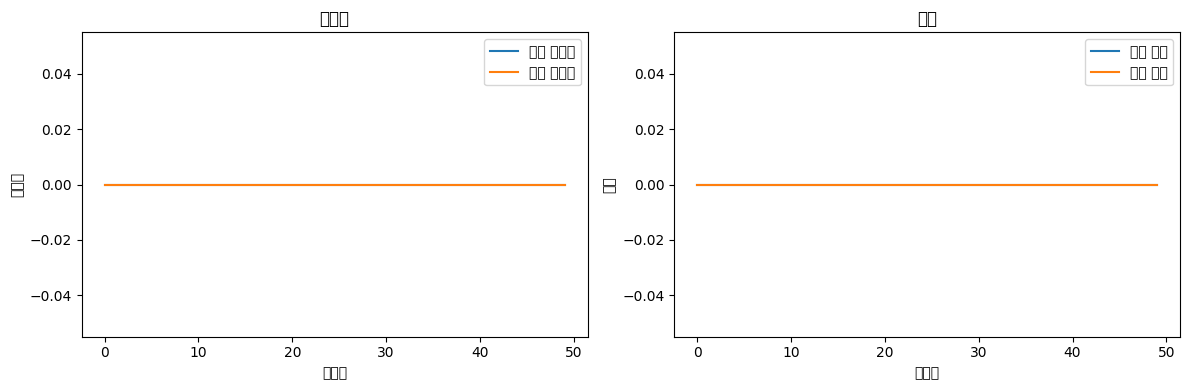

In [12]:
# 정확도 그래프
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='학습 정확도')
plt.plot(history.history['val_accuracy'], label='검증 정확도')
plt.title('정확도')
plt.xlabel('에포크')
plt.ylabel('정확도')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='학습 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.title('손실')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
spark.stop()